## <span style="color: blue;">1️⃣ <b><u>Import Libraries</u></b> </span>

In [23]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import pandas as pd
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import GOOG
from pandas_datareader import data as web
import talib

import warnings
warnings.filterwarnings('ignore')

## <span style="color: green;">2️⃣ <b><u>Pull Data From Yahoo Finance</u></b></span>

In [27]:
# Define the function to get stock data
def get_stock_data(ticker, start_date, end_date, interval):
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    df.dropna(inplace=True)
    
    # Drop the 'Adj Close' column if it exists
    if 'Adj Close' in df.columns:
        df.drop(columns=['Adj Close'], inplace=True)
    
    # Ensure single-level column names
    df.columns = df.columns.get_level_values(0)  # Flatten columns
    df.columns.name = None  # Remove the name attribute from columns

    # Reset index to include Date column
    df.reset_index(inplace=True)
    df.set_index('Date', inplace=True)
    
    # Ensure columns are in correct order
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    return df

## 3️⃣ <span style="color: red;"><b><u>Backtesting Trading Strategies</u></b></span>

### Configuring Global Variables

In [29]:
# List of stocks (holdings of FBGRX)
holdings = ['MSFT', 'AAPL', 'AMZN', 'GOOGL', 'META']

# Define the time period
start_date = '2010-01-01'
end_date = '2023-12-31'

# Fund to be invested for backtesting
cash_in_hand = 10000

# Brokerage to be assumed for backtesting
brokerage = .002

### <b> 1. </b> Moving Average Ribbon Strategy [Parv] 🟢

In [57]:
# Moving Average Ribbon Strategy
class MovingAverageRibbonStrategy(Strategy):
    short_window = 10  # Shortest moving average
    long_window = 50  # Longest moving average
    stop_loss_percent = 0.02  # Stop loss at 2%

    def init(self):
        # Convert Close prices to Pandas Series and calculate moving averages
        close_series = pd.Series(self.data.Close, index=self.data.index)
        self.short_ma = self.I(lambda: close_series.rolling(self.short_window).mean())
        self.long_ma = self.I(lambda: close_series.rolling(self.long_window).mean())

    def next(self):
        if len(self.data) < self.long_window:
            return

        # Buy Signal: Short MA crosses above Long MA
        if not self.position and crossover(self.short_ma, self.long_ma):
            self.buy(sl=self.data.Close[-1] * (1 - self.stop_loss_percent))

        # Sell Signal: Short MA crosses below Long MA
        elif self.position and crossover(self.long_ma, self.short_ma):
            self.sell()


# Applying the Moving Average Ribbon Strategy
# Create a DataFrame to store yearly returns for each stock
yearly_returns_df_mar = pd.DataFrame()

# Backtest the strategy for each stock in holdings
for ticker in holdings:
    print(f"\nBacktesting Moving Average Ribbon strategy for {ticker}")
    
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, MovingAverageRibbonStrategy, cash=cash_in_hand, commission=brokerage)
    stats = bt.run()
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().fillna(0) * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_mar[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for the strategy
average_yearly_returns_mar = yearly_returns_df_mar.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_mar = pd.DataFrame({
    'Date': yearly_returns_df_mar.index,
    'Average Yearly Returns (%)': average_yearly_returns_mar
})

# Plot the Output of Strategy application
print(stats)
print("---------------")

# Plot the Chart
bt.plot()
print("---------------")

# Print the DataFrame
print(average_yearly_returns_df_mar)

# Comparing with the mutual fund
mutual_fund_ticker = 'FBGRX'  # Fidelity Blue Chip Growth Fund
mutual_fund = yf.Ticker(mutual_fund_ticker)
historical_data = mutual_fund.history(start=start_date, end=end_date)
yearly_data = historical_data['Close'].resample('Y').last()
mutual_fund_yearly_returns = yearly_data.pct_change().fillna(0) * 100

print(mutual_fund_yearly_returns)


[*********************100%***********************]  1 of 1 completed


Backtesting Moving Average Ribbon strategy for MSFT

Backtesting Moving Average Ribbon strategy for AAPL



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Backtesting Moving Average Ribbon strategy for AMZN

Backtesting Moving Average Ribbon strategy for GOOGL


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Backtesting Moving Average Ribbon strategy for META
Start                     2012-05-18 00:00...
End                       2023-12-29 00:00...
Duration                   4242 days 00:00:00
Exposure Time [%]                   90.249743
Equity Final [$]                129255.548404
Equity Peak [$]                 137603.949282
Return [%]                        1192.555484
Buy & Hold Return [%]              825.869725
Return (Ann.) [%]                    24.68699
Volatility (Ann.) [%]               47.148082
Sharpe Ratio                         0.523605
Sortino Ratio                        0.998363
Calmar Ratio                         0.321758
Max. Drawdown [%]                  -76.725411
Avg. Drawdown [%]                   -5.050109
Max. Drawdown Duration      843 days 00:00:00
Avg. Drawdown Duration       35 days 00:00:00
# Trades                                    4
Win Rate [%]                             25.0
Best Trade [%]                    1281.694713
Worst Trade [%]            

---------------
    Date  Average Yearly Returns (%)
0      0                         0.0
1      1                         0.0
2      2                         0.0
3      3                         0.0
4      4                         0.0
5      5                         0.0
6      6                         0.0
7      7                         0.0
8      8                         0.0
9      9                         0.0
10    10                         0.0
11    11                         0.0
12    12                         0.0
13    13                         0.0
Date
2010-12-31 00:00:00-05:00     0.000000
2011-12-31 00:00:00-05:00    -2.824671
2012-12-31 00:00:00-05:00    17.750640
2013-12-31 00:00:00-05:00    39.848295
2014-12-31 00:00:00-05:00    14.617621
2015-12-31 00:00:00-05:00     6.316546
2016-12-31 00:00:00-05:00     1.597592
2017-12-31 00:00:00-05:00    36.092866
2018-12-31 00:00:00-05:00     1.017665
2019-12-31 00:00:00-05:00    33.427716
2020-12-31 00:00:00-05:00    62.19

### <b> 2. </b> SuperTrend Strategy [Parv] 🔴 errors

In [52]:
def supertrend_strategy(df, atr_period=7, multiplier=3):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    tr = pd.DataFrame([high_low, high_close, low_close]).max(axis=0)
    atr = tr.rolling(atr_period).mean()
    
    df['Upper_Band'] = (df['High'] + df['Low']) / 2 + (multiplier * atr)
    df['Lower_Band'] = (df['High'] + df['Low']) / 2 - (multiplier * atr)
    df['Supertrend'] = np.nan
    
    for i in range(1, len(df)):
        if df['Close'][i] > df['Upper_Band'][i - 1]:
            df['Supertrend'][i] = df['Lower_Band'][i]
        elif df['Close'][i] < df['Lower_Band'][i - 1]:
            df['Supertrend'][i] = df['Upper_Band'][i]
        else:
            df['Supertrend'][i] = df['Supertrend'][i - 1]
    
    df['Signal'] = np.where(df['Close'] > df['Supertrend'], 1, 0)
    
    return df

### <b> 3. </b> Volatility Breakout Strategy [Parv] 🟢

In [60]:
# Define the Volatility Breakout Strategy
class VolatilityBreakoutStrategy(Strategy):
    atr_period = 14  # ATR calculation period
    breakout_multiplier = 2.0  # Multiplier for breakout levels

    def init(self):
        # Calculate the ATR (Average True Range)
        self.atr = self.I(talib.ATR, self.data.High, self.data.Low, self.data.Close, self.atr_period)

    def next(self):
        # Calculate breakout levels
        breakout_high = self.data.Close[-1] + self.breakout_multiplier * self.atr[-1]
        breakout_low = self.data.Close[-1] - self.breakout_multiplier * self.atr[-1]

        # Entry and exit conditions
        if not self.position:  # If no position is held
            if self.data.Close[-1] > breakout_high:  # Price breaks above the high breakout level
                self.buy()
            elif self.data.Close[-1] < breakout_low:  # Price breaks below the low breakout level
                self.sell()
        elif self.position.is_long and self.data.Close[-1] < breakout_low:
            self.position.close()  # Close long position if price falls below the low breakout level
        elif self.position.is_short and self.data.Close[-1] > breakout_high:
            self.position.close()  # Close short position if price rises above the high breakout level

# Create a DataFrame to store yearly returns for each stock
yearly_returns_df_volatility = pd.DataFrame()

# Apply the Volatility Breakout Strategy to each stock and calculate yearly returns
for ticker in holdings:
    print(f"\nBacktesting Volatility Breakout strategy for {ticker}")
    
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, VolatilityBreakoutStrategy, cash=cash_in_hand, commission=brokerage)
    stats = bt.run()
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().fillna(0) * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_volatility[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for the Volatility Breakout strategy
average_yearly_returns_volatility = yearly_returns_df_volatility.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_volatility = pd.DataFrame({
    'Date': yearly_returns_df_volatility.index,
    'Average Yearly Returns (%)': average_yearly_returns_volatility
})

# Plot the Output of Strategy application
print(stats)
print("---------------")

# Plot the Chart
bt.plot()
print("---------------")

# Print the DataFrame
print(average_yearly_returns_df_volatility)


[*********************100%***********************]  1 of 1 completed


Backtesting Volatility Breakout strategy for MSFT



[*********************100%***********************]  1 of 1 completed


Backtesting Volatility Breakout strategy for AAPL



[*********************100%***********************]  1 of 1 completed


Backtesting Volatility Breakout strategy for AMZN

Backtesting Volatility Breakout strategy for GOOGL



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Backtesting Volatility Breakout strategy for META
Start                     2012-05-18 00:00...
End                       2023-12-29 00:00...
Duration                   4242 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]              825.869725
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]              

---------------
    Date  Average Yearly Returns (%)
0      0                         0.0
1      1                         0.0
2      2                         0.0
3      3                         0.0
4      4                         0.0
5      5                         0.0
6      6                         0.0
7      7                         0.0
8      8                         0.0
9      9                         0.0
10    10                         0.0
11    11                         0.0
12    12                         0.0
13    13                         0.0


### <b> 4. </b> Money Flow Index (MFI) Strategy [Anand] 🟢

In [31]:
# Define the MFI Strategy using backtesting.py    
class MFI_Strategy(Strategy):
    window_size = 14
    
    def init(self):
        # Initialize the necessary variables
        self.money_flow = self.data.Volume * (self.data.Close - self.data.Low) - (self.data.High - self.data.Close)
        self.mfi = self.I(self.calculate_mfi)

    def calculate_mfi(self):
        # Compute the MFI values
        mf_ratio = self.money_flow / self.data.Volume
        # Ensure the output has the same length as the input data
        mfi_values = pd.Series(mf_ratio).rolling(window=self.window_size).mean()  # Adjust rolling window size as needed
        # Pad the first few values with NaN or zeros, depending on your requirements
        return mfi_values.fillna(0).values  # Or use .shift() if you need specific lag handling

    def next(self):
        # Ensure the strategy has valid MFI values
        if np.isnan(self.mfi[-1]):
            return

        # If no position is held and MFI is oversold (below 20), buy
        if not self.position and self.mfi[-1] < 20:
            self.buy()
        
        # If position is held and MFI is overbought (above 80), sell
        elif self.position and self.mfi[-1] > 80:
            self.sell()

# Create a DataFrame to store yearly returns for each stock
yearly_returns_df_4 = pd.DataFrame()

# Apply the MFI_Strategy to each stock and calculate yearly returns
for ticker in holdings:
    #print(f"\nBacktesting MFI strategy for {ticker}")
    
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, MFI_Strategy, cash=10000, commission=0.002)
    stats = bt.run()
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().fillna(0) * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_4[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for the MFI strategy
average_yearly_returns_4 = yearly_returns_df_4.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_4 = pd.DataFrame({
    'Date': yearly_returns_df_4.index,
    'Average Yearly Returns (%)': average_yearly_returns_4
})

# Plot the Output of Strategy application
print(stats)
print("---------------")

# Plot the Chart
bt.plot()
print("---------------")

# Print the DataFrame
print(average_yearly_returns_df_4)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Start                     2012-05-18 00:00...
End                       2023-12-29 00:00...
Duration                   4242 days 00:00:00
Exposure Time [%]                   99.931577
Equity Final [$]                109852.319505
Equity Peak [$]                 116948.460252
Return [%]                         998.523195
Buy & Hold Return [%]              825.869725
Return (Ann.) [%]                   22.950719
Volatility (Ann.) [%]               51.071153
Sharpe Ratio                         0.449387
Sortino Ratio                        0.851412
Calmar Ratio                          0.29909
Max. Drawdown [%]                  -76.735184
Avg. Drawdown [%]                   -5.505638
Max. Drawdown Duration      843 days 00:00:00
Avg. Drawdown Duration       35 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     998.661259
Worst Trade [%]                    998.661259
Avg. Trade [%]                    

---------------
    Date  Average Yearly Returns (%)
0      0                         0.0
1      1                         0.0
2      2                         0.0
3      3                         0.0
4      4                         0.0
5      5                         0.0
6      6                         0.0
7      7                         0.0
8      8                         0.0
9      9                         0.0
10    10                         0.0
11    11                         0.0
12    12                         0.0
13    13                         0.0


### <b> 5. </b> Volume Price Trend (VPT) Strategy [Anand] 🟢

In [45]:
class VPT_Strategy(Strategy):
    def init(self):
        self.vpt = self.I(self.calculate_vpt)

    def calculate_vpt(self):
        close = pd.Series(self.data.Close)
        volume = pd.Series(self.data.Volume)
        price_change = close.pct_change()
        vpt = ((price_change * volume).cumsum()).fillna(0)
        return vpt
    
    def next(self):
        if len(self.vpt) < 2:
            return

        if self.vpt[-1] > self.vpt[-2] and not self.position:
            #print(f"Buying at {self.data.Close[-1]}")
            self.buy()
        elif self.vpt[-1] < self.vpt[-2] and self.position:
            #print(f"Selling at {self.data.Close[-1]}")
            self.sell()

# Create a DataFrame to store yearly returns for each stock
yearly_returns_df_5 = pd.DataFrame()

# Apply the VPT_Strategy to each stock and calculate yearly returns
for ticker in holdings:
    #print(f"\nBacktesting VPT strategy for {ticker}")
    
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, VPT_Strategy, cash=10000, commission=0.002)
    stats = bt.run()
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().fillna(0) * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_5[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for the VPT strategy
average_yearly_returns_5 = yearly_returns_df_5.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_5 = pd.DataFrame({
    'Date': yearly_returns_df_5.index,
    'Average Yearly Returns (%)': average_yearly_returns_5
})

# Plot the Output of Strategy application
print(stats)
print("---------------")

# Plot the Chart
bt.plot()
print("---------------")

# Print the DataFrame
print(average_yearly_returns_df_5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Start                     2012-05-18 00:00...
End                       2023-12-29 00:00...
Duration                   4242 days 00:00:00
Exposure Time [%]                   10.126582
Equity Final [$]                          0.0
Equity Peak [$]                  15084.325493
Return [%]                             -100.0
Buy & Hold Return [%]              825.869725
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              637.788738
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                   -33.92992
Max. Drawdown Duration     4133 days 00:00:00
Avg. Drawdown Duration     1056 days 00:00:00
# Trades                                   18
Win Rate [%]                              0.0
Best Trade [%]                      -4.076523
Worst Trade [%]                   -108.547633
Avg. Trade [%]                    

---------------
    Date  Average Yearly Returns (%)
0      0                         0.0
1      1                         0.0
2      2                         0.0
3      3                         0.0
4      4                         0.0
5      5                         0.0
6      6                         0.0
7      7                         0.0
8      8                         0.0
9      9                         0.0
10    10                         0.0
11    11                         0.0
12    12                         0.0
13    13                         0.0


### <b> 6. </b> Heikin-Ashi Candlesticks Strategy [Anand] 🟢

In [47]:
# Define Heikin-Ashi Strategy
class HeikinAshiStrategy(Strategy):
    def init(self):
        """
        Initialize strategy by calculating Heikin-Ashi candles.
        """
        # Heikin-Ashi calculations
        self.ha_open = self.I(self.calculate_ha_open)
        self.ha_close = self.I(self.calculate_ha_close)
        
        # Track signals
        self.signal = np.zeros(len(self.data.Close))
        self.signal = self.I(self.calculate_signals)
        
    def calculate_ha_close(self):
        """
        Calculate Heikin-Ashi Close as the average of Open, High, Low, and Close.
        """
        return (self.data.Open + self.data.High + self.data.Low + self.data.Close) / 4

    def calculate_ha_open(self):
        """
        Calculate Heikin-Ashi Open as the average of the previous Open and Close.
        """
        ha_open = np.zeros_like(self.data.Close)
        ha_open[0] = (self.data.Open[0] + self.data.Close[0]) / 2  # Initialize
        for i in range(1, len(self.data.Close)):
            ha_open[i] = (ha_open[i - 1] + self.calculate_ha_close()[i - 1]) / 2
        return ha_open

    def calculate_signals(self):
        """
        Generate buy/sell signals based on Heikin-Ashi candle patterns.
        Buy when HA_Close > HA_Open and Sell when HA_Close < HA_Open.
        """
        ha_open = self.calculate_ha_open()
        ha_close = self.calculate_ha_close()
        
        signal = np.zeros(len(self.data.Close))
        signal[ha_close > ha_open] = 1  # Buy
        signal[ha_close < ha_open] = -1  # Sell
        return signal

    def next(self):
        """
        Define trading logic:
        - Buy when signal is 1.
        - Sell when signal is -1 and position exists.
        """
        if not self.position and self.signal[-1] == 1:
            self.buy()
        elif self.position and self.signal[-1] == -1:
            self.sell()

# Create a DataFrame to store yearly returns for each stock
yearly_returns_df_6 = pd.DataFrame()

# Apply the HeikinAshiStrategy to each stock and calculate yearly returns
for ticker in holdings:
    #print(f"\nBacktesting Heikin-Ashi strategy for {ticker}")
    
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, HeikinAshiStrategy, cash=10000, commission=0.002)
    stats = bt.run()
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().fillna(0) * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_6[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for the Heikin-Ashi strategy
average_yearly_returns_6 = yearly_returns_df_6.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_6 = pd.DataFrame({
    'Date': yearly_returns_df_6.index,
    'Average Yearly Returns (%)': average_yearly_returns_6
})

# Plot the Output of Strategy application
print(stats)
print("---------------")

# Plot the Chart
bt.plot()
print("---------------")

# Print the DataFrame
print(average_yearly_returns_df_6)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Start                     2012-05-18 00:00...
End                       2023-12-29 00:00...
Duration                   4242 days 00:00:00
Exposure Time [%]                   99.486829
Equity Final [$]                133336.827083
Equity Peak [$]                  140265.04708
Return [%]                        1233.368271
Buy & Hold Return [%]              825.869725
Return (Ann.) [%]                   25.021612
Volatility (Ann.) [%]               51.505667
Sharpe Ratio                         0.485803
Sortino Ratio                        0.939668
Calmar Ratio                         0.326085
Max. Drawdown [%]                  -76.733362
Avg. Drawdown [%]                   -5.256928
Max. Drawdown Duration      843 days 00:00:00
Avg. Drawdown Duration       34 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                    1218.150991
Worst Trade [%]                   1218.150991
Avg. Trade [%]                    

---------------
    Date  Average Yearly Returns (%)
0      0                         0.0
1      1                         0.0
2      2                         0.0
3      3                         0.0
4      4                         0.0
5      5                         0.0
6      6                         0.0
7      7                         0.0
8      8                         0.0
9      9                         0.0
10    10                         0.0
11    11                         0.0
12    12                         0.0
13    13                         0.0


### <b> 7. </b> Renko Chart Strategy [Neel] - BUG 🔴

In [455]:
def calculate_renko(df, brick_size):
    df['Direction'] = None
    df['Renko'] = None
    for i in range(1, len(df)):
        if df['Close'][i] >= df['Close'][i-1] + brick_size:
            df.loc[df.index[i], 'Direction'] = 'Up'
            df.loc[df.index[i], 'Renko'] = df['Close'][i-1] + brick_size
        elif df['Close'][i] <= df['Close'][i-1] - brick_size:
            df.loc[df.index[i], 'Direction'] = 'Down'
            df.loc[df.index[i], 'Renko'] = df['Close'][i-1] - brick_size
    df.dropna(inplace=True)
    return df[['Renko']]

class RenkoStrategy(Strategy):
    brick_size = 2  # Define the size of the Renko bricks

    def init(self):
        # Use the pre-calculated renko data
        close_prices = self.data.Close
        self.renko = calculate_renko(pd.DataFrame({'Close': close_prices}), brick_size=self.brick_size)['Renko'].values

    def next(self):
        # Ensure Renko bricks are calculated
        if len(self.renko) < 2 or np.isnan(self.renko[-1]) or np.isnan(self.renko[-2]):
            return

        # Prevent selling if no position is held
        if not self.position and self.renko[-1] < self.renko[-2]:
            # print("Ignoring sell signal because no position is held")
            return

        # Simple trading logic based on Renko bricks
        # Buy when a new Renko brick is formed upwards
        # Sell when a new Renko brick is formed downwards
        if self.renko[-1] > self.renko[-2]:
            print("Buying")
            self.buy()
        elif self.renko[-1] < self.renko[-2]:
            print("Selling")
            self.sell()

# Example usage with sample data
ticker = 'AAPL'

# Download historical data for backtesting
df = get_stock_data(ticker, start_date, end_date, '1d')

# Backtest the strategy
bt = Backtest(df, RenkoStrategy, cash=cash_in_hand, commission=brokerage)
stats = bt.run()
print(stats)
#bt.plot()

[*********************100%***********************]  1 of 1 completed


Start                     2010-01-04 00:00:00
End                       2023-12-29 00:00:00
Duration                   5107 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]             2418.966407
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

### <b> 8. </b> Mean Reversion with Bollinger Bands and RSI Strategy [Neel] 🟢

In [50]:
class MeanReversionBBandRSI(Strategy):
    bb_window = 20
    rsi_window = 14
    upper_bb = 2
    lower_bb = 2

    def init(self):
        # Calculate Bollinger Bands
        close_prices = self.data.Close
        self.upper_band, self.middle_band, self.lower_band = self.I(talib.BBANDS, close_prices, timeperiod=self.bb_window, nbdevup=self.upper_bb, nbdevdn=self.lower_bb)
        
        # Calculate RSI
        self.rsi = self.I(talib.RSI, close_prices, timeperiod=self.rsi_window)

    def next(self):
        # Ensure that both Bollinger Bands and RSI are valid before proceeding
        if np.isnan(self.upper_band[-1]) or np.isnan(self.lower_band[-1]) or np.isnan(self.rsi[-1]):
            return

        # Prevent selling if no position is held
        if not self.position and self.data.Close[-1] > self.upper_band[-1] and self.rsi[-1] > 70:
            # print("Ignoring sell signal because no position is held")
            return

        # Trading logic based on Bollinger Bands and RSI
        if self.data.Close[-1] < self.lower_band[-1] and self.rsi[-1] < 30:
            # print("Buying")
            self.buy()
        elif self.data.Close[-1] > self.upper_band[-1] and self.rsi[-1] > 70:
            # print("Selling")
            self.sell()

# Create a DataFrame to store yearly returns for each stock for MeanReversionBBandRSI strategy
yearly_returns_df_2 = pd.DataFrame()

# Apply the MeanReversionBBandRSI strategy to each stock and calculate yearly returns
for ticker in holdings:
    print(f"\nBacktesting strategy for {ticker} using MeanReversionBBandRSI")
    
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, MeanReversionBBandRSI, cash=cash_in_hand, commission=brokerage)
    stats = bt.run()
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().dropna() * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df_2[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks for MeanReversionBBandRSI strategy
average_yearly_returns_2 = yearly_returns_df_2.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_8 = pd.DataFrame({
    'Date': yearly_returns_df_2.index,
    'Average Yearly Returns (%)': average_yearly_returns_2
})

# Plot the Output of Strategy application
print(stats)
print("---------------")

# Plot the Chart
bt.plot()
print("---------------")

# Print the DataFrame
print(average_yearly_returns_df_8)

[*********************100%***********************]  1 of 1 completed


Backtesting strategy for MSFT using MeanReversionBBandRSI



[*********************100%***********************]  1 of 1 completed


Backtesting strategy for AAPL using MeanReversionBBandRSI

Backtesting strategy for AMZN using MeanReversionBBandRSI



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Backtesting strategy for GOOGL using MeanReversionBBandRSI



[*********************100%***********************]  1 of 1 completed


Backtesting strategy for META using MeanReversionBBandRSI
Start                     2012-05-18 00:00...
End                       2023-12-29 00:00...
Duration                   4242 days 00:00:00
Exposure Time [%]                    98.32364
Equity Final [$]                149000.925947
Equity Peak [$]                  158624.77696
Return [%]                        1390.009259
Buy & Hold Return [%]              825.869725
Return (Ann.) [%]                    26.22457
Volatility (Ann.) [%]               51.296181
Sharpe Ratio                         0.511238
Sortino Ratio                        1.003783
Calmar Ratio                         0.341793
Max. Drawdown [%]                  -76.726378
Avg. Drawdown [%]                   -5.372539
Max. Drawdown Duration      843 days 00:00:00
Avg. Drawdown Duration       33 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                    1392.806014
Worst Trade [%]      

---------------
    Date  Average Yearly Returns (%)
0      0                         0.0
1      1                         0.0
2      2                         0.0
3      3                         0.0
4      4                         0.0
5      5                         0.0
6      6                         0.0
7      7                         0.0
8      8                         0.0
9      9                         0.0
10    10                         0.0
11    11                         0.0
12    12                         0.0
13    13                         0.0


### <b> 9. </b> Dual Moving Average Strategy [Neel] 🟢

In [67]:
class DualMovingAverage(Strategy):
    short_window = 50
    long_window = 200

    def init(self):
        close_prices = self.data.Close
        self.short_ma = self.I(talib.SMA, close_prices, timeperiod=self.short_window)
        self.long_ma = self.I(talib.SMA, close_prices, timeperiod=self.long_window)

    def next(self):
        if np.isnan(self.short_ma[-1]) or np.isnan(self.long_ma[-1]):
            return

        # Prevent selling if there are no positions to sell
        if not self.position and crossover(self.long_ma, self.short_ma):
            # print("Ignoring sell signal because no position is held")
            return

        if crossover(self.short_ma, self.long_ma):
            # print("Buying")
            self.buy()
        elif crossover(self.long_ma, self.short_ma):
            # print("Selling")
            self.sell()
            
# Create a DataFrame to store yearly returns for each stock
yearly_returns_df = pd.DataFrame()

# Apply the strategy to each stock and calculate yearly returns
for ticker in holdings:
    #print(f"\nBacktesting strategy for {ticker}")
    
    # Download historical data for backtesting
    df = get_stock_data(ticker, start_date, end_date, '1d')
    
    # Backtest the strategy
    bt = Backtest(df, DualMovingAverage, cash=cash_in_hand, commission=brokerage)
    stats = bt.run()
    
    # Extract the equity curve and calculate yearly returns
    equity_curve = stats['_equity_curve']['Equity']
    yearly_returns = equity_curve.resample('Y').last().pct_change().dropna() * 100
    
    # Ensure the DataFrame has all years from start_date to end_date
    all_years = pd.date_range(start=start_date, end=end_date, freq='Y')
    yearly_returns = yearly_returns.reindex(all_years, fill_value=0)
    
    yearly_returns_df[ticker] = yearly_returns.values

# Calculate the average yearly returns across all stocks
average_yearly_returns = yearly_returns_df.mean(axis=1)

# Create a DataFrame with "Date" and "Average Yearly Returns (%)"
average_yearly_returns_df_9 = pd.DataFrame({
    'Date': yearly_returns_df.index,
    'Average Yearly Returns (%)': average_yearly_returns
})

# Plot the Output of Strategy application
print(stats)
print("---------------")

# Plot the Chart
bt.plot()
print("---------------")

# Print the DataFrame
print(average_yearly_returns_df_9)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Start                     2012-05-18 00:00...
End                       2023-12-29 00:00...
Duration                   4242 days 00:00:00
Exposure Time [%]                   89.599726
Equity Final [$]                 91549.451254
Equity Peak [$]                  97462.901876
Return [%]                         815.494513
Buy & Hold Return [%]              825.869725
Return (Ann.) [%]                   21.033901
Volatility (Ann.) [%]               44.231286
Sharpe Ratio                         0.475544
Sortino Ratio                        0.852331
Calmar Ratio                         0.274127
Max. Drawdown [%]                  -76.730577
Avg. Drawdown [%]                   -5.097524
Max. Drawdown Duration      843 days 00:00:00
Avg. Drawdown Duration       33 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     816.066064
Worst Trade [%]                    816.066064
Avg. Trade [%]                    

---------------
    Date  Average Yearly Returns (%)
0      0                         0.0
1      1                         0.0
2      2                         0.0
3      3                         0.0
4      4                         0.0
5      5                         0.0
6      6                         0.0
7      7                         0.0
8      8                         0.0
9      9                         0.0
10    10                         0.0
11    11                         0.0
12    12                         0.0
13    13                         0.0


## <span style="color: brown;">4️⃣ <u><b>Comparing with TD Mutual Fund</b></u></span>

### Getting Mutual Fund Historical Returns

In [33]:
# Define the mutual fund ticker
mutual_fund_ticker = 'FBGRX'  # Fidelity Blue Chip Growth Fund

# Create a Ticker object
mutual_fund = yf.Ticker(mutual_fund_ticker)

historical_data = mutual_fund.history(start=start_date, end=end_date)

# Resample data to get yearly data
yearly_data = historical_data['Close'].resample('Y').last()
mutual_fund_yearly_returns = yearly_data.pct_change().fillna(0) * 100

print(mutual_fund_yearly_returns)

Date
2010-12-31 00:00:00-05:00     0.000000
2011-12-31 00:00:00-05:00    -2.824671
2012-12-31 00:00:00-05:00    17.750640
2013-12-31 00:00:00-05:00    39.848295
2014-12-31 00:00:00-05:00    14.617621
2015-12-31 00:00:00-05:00     6.316546
2016-12-31 00:00:00-05:00     1.597592
2017-12-31 00:00:00-05:00    36.092866
2018-12-31 00:00:00-05:00     1.017665
2019-12-31 00:00:00-05:00    33.427716
2020-12-31 00:00:00-05:00    62.198250
2021-12-31 00:00:00-05:00    22.638970
2022-12-31 00:00:00-05:00   -38.449666
2023-12-31 00:00:00-05:00    55.608395
Freq: YE-DEC, Name: Close, dtype: float64


### Plot the Yearly Average Comparison (Mutual Fund Vs All Strategies)

<Figure size 2600x2000 with 0 Axes>

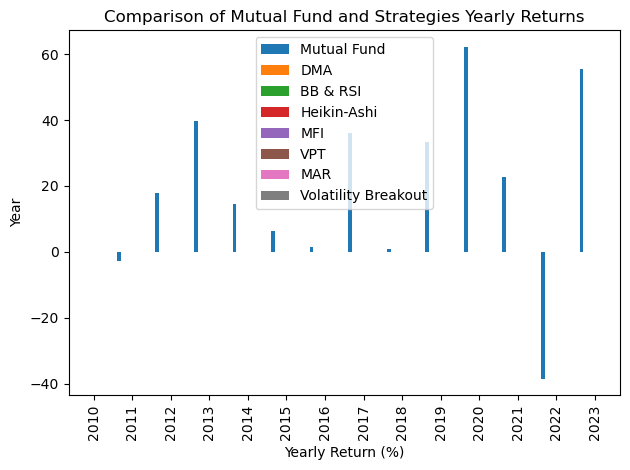

    Date  Mutual Fund  DMA  BB & RSI  Heikin-Ashi  MFI  VPT  MAR  \
0   2010     0.000000  0.0       0.0          0.0  0.0  0.0  0.0   
1   2011    -2.824671  0.0       0.0          0.0  0.0  0.0  0.0   
2   2012    17.750640  0.0       0.0          0.0  0.0  0.0  0.0   
3   2013    39.848295  0.0       0.0          0.0  0.0  0.0  0.0   
4   2014    14.617621  0.0       0.0          0.0  0.0  0.0  0.0   
5   2015     6.316546  0.0       0.0          0.0  0.0  0.0  0.0   
6   2016     1.597592  0.0       0.0          0.0  0.0  0.0  0.0   
7   2017    36.092866  0.0       0.0          0.0  0.0  0.0  0.0   
8   2018     1.017665  0.0       0.0          0.0  0.0  0.0  0.0   
9   2019    33.427716  0.0       0.0          0.0  0.0  0.0  0.0   
10  2020    62.198250  0.0       0.0          0.0  0.0  0.0  0.0   
11  2021    22.638970  0.0       0.0          0.0  0.0  0.0  0.0   
12  2022   -38.449666  0.0       0.0          0.0  0.0  0.0  0.0   
13  2023    55.608395  0.0       0.0          0.

In [78]:
# Merge data for comparison
comparison_df = pd.DataFrame({
    'Date': mutual_fund_yearly_returns.index.year,
    'Mutual Fund': mutual_fund_yearly_returns.values,
    'DMA': average_yearly_returns_df_9['Average Yearly Returns (%)'].values,
    'BB & RSI': average_yearly_returns_df_8['Average Yearly Returns (%)'].values,
    'Heikin-Ashi': average_yearly_returns_df_6['Average Yearly Returns (%)'].values,
    'MFI': average_yearly_returns_df_4['Average Yearly Returns (%)'].values,
    'VPT': average_yearly_returns_df_5['Average Yearly Returns (%)'].values,
    'MAR': average_yearly_returns_df_mar['Average Yearly Returns (%)'].values,
    'Volatility Breakout': average_yearly_returns_df_volatility['Average Yearly Returns (%)'].values 
})

# Plot the comparison using horizontal bars
plt.figure(figsize=(26, 20))
ax = comparison_df.set_index('Date').plot(kind='bar', title="Comparison of Mutual Fund and Strategies Yearly Returns", width=0.8)
plt.xlabel("Yearly Return (%)")
plt.ylabel("Year")
plt.legend(loc='best')
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Print the DataFrame
print(comparison_df)